CST 383 Weather Project

Team Members 

Arlon Arriola larriola@csumb.edu

Benjamin Mona bmona@csumb.edu

Rahul Khurana rkhurana@csumb.edu 

Cristian Serrano crserrano@csumb.edu 


Our goal: We will create a system that can take in rainfall from previous months/years, and will attempt to use the Nearest Neighbors algorithm, to accurately predict future rainfall in certain months, and test it on past months. Our hope is to be able to replicate this prediction among various areas in the United States and various months across years as a proof of concept. We will start with a specific month across years in a specific area, such as the months of April at CSUMB, Seaside, 93955. To do that we will start by getting a data set with several Aprils worth of weather data, and try and predict other Aprils' weather, in the past for testing, and in the future for fun.


The key parts of your project that you should cover in this update are:


*  choice of dataset: New York street data from cityofnewyork.us & broader world weather data from worldweatheronline.com...openweathermap...no, rapidapi....
*  what it is you are going to predict: Amount of precipitation in a given period
*  what features you plan to use as predictors: Historical amounts of precipitation
*  some preprocessing
*  some exploration and visualization
*  preliminary work on machine learning; such as test/train dataset split

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
sns.set()
rcParams['figure.figsize'] = 8,6
sns.set_context('talk') 

In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')


In [ ]:
#@title New York Street Temperature Data - step 1 - get the data
#https://data.cityofnewyork.us/api/views/qdq3-9eqn/rows.csv?accessType=DOWNLOAD
#df = pd.read_csv ('Hyperlocal_Temperature_Monitoring.csv') 
df = pd.read_csv ('https://data.cityofnewyork.us/api/views/qdq3-9eqn/rows.csv')


In [ ]:
#@title New York Street Temperature Data - step 2 - parse the data - take 1
temperature = df[["AirTemp"]]
temperature.groupby(np.arange(len(temperature))//24).mean()
grouped_ID = df.groupby(['Sensor.ID'])
BkBR_01 = grouped_ID.get_group("Bk-BR_01")

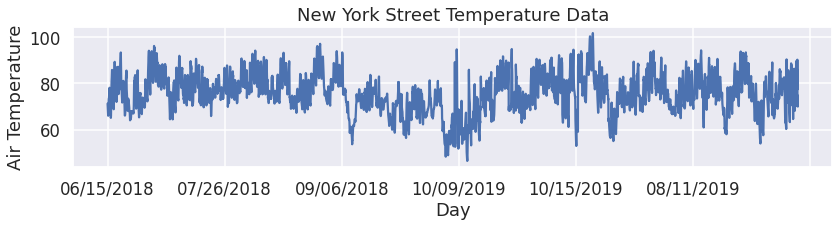

In [ ]:
#@title New York Street Temperature Data - step 3 - Graph Air Temperatures
#_=BkBR_01.plot.line(x = 'Day', y = 'AirTemp') 
plt.rcParams["figure.figsize"] = [12.0, 3.50] 
plt.rcParams["figure.autolayout"] = True
_=BkBR_01.plot.line(x = 'Day', y = 'AirTemp', xlabel='Day', ylabel='Air Temperature', title='New York Street Temperature Data', legend=None)

Our second dataset, from worldweatheronline can get us weather from any area, for example, Seaside, CA, where CSUMB is:

In [ ]:
#@title Get CSUMB (Seaside/93955) Weather Data in 2020 - step 1 - create a URL - take 1
#https://www.worldweatheronline.com/developer/premium-api-explorer.aspx
#8dfa1916aa894234ab663422222405#Arlon's API key
#wwo_df=pd.read_json('http://api.worldweatheronline.com/premium/v1/weather.ashx?key=8dfa1916aa894234ab663422222405&q=93955&format=json&num_of_days=1&date=2013-04-21')
#https://towardsdatascience.com/how-to-parse-json-data-with-python-pandas-f84fbd0b1025
wwo_url_0=''.join("""
http://api.worldweatheronline.com
/premium/v1/weather.ashx
?key=8dfa1916aa894234ab663422222405
&q=93955
&format=json
&num_of_days=1
&date=2020-03-12
&enddate=2020-03-13
""".split('\n'))

In [ ]:
#@title Get CSUMB (Seaside/93955) Weather Data in 2020 - step 2 - request the data located at that URL - part 1 - setup:
#CSUMB/Seaside Weather take 2:
class Wwo: # worldweatheronline.com
    def __init__(self, name="anything"):
        self.name = name
        self.file_already_loaded=False # there could be other queries, other calls, other json files requested...
        #https://www.worldweatheronline.com/developer/premium-api-explorer.aspx
        #8dfa1916aa894234ab663422222405#Arlon's API key
        #wwo_df=pd.read_json('http://api.worldweatheronline.com/premium/v1/weather.ashx?key=8dfa1916aa894234ab663422222405&q=93955&format=json&num_of_days=1&date=2013-04-21')
        #https://towardsdatascience.com/how-to-parse-json-data-with-python-pandas-f84fbd0b1025
        self.wwo_url_0=''.join("""
http://api.worldweatheronline.com
/premium/v1/weather.ashx
?key=8dfa1916aa894234ab663422222405
&q=93955
&format=json
&num_of_days=1
&date=2020-03-12
&enddate=2020-03-13"""\
            .split('\n')) # I split that into multi-lines so we can get at the parameters easier
    def load_from_(self,url=-1,headers={},params={}): # the urls going to change, this is just a first draft
        #https://stackoverflow.com/questions/5555449/using-self-xxxx-as-a-default-parameter-python/5555470#5555470
        if url == -1:
            url=self.wwo_url_0
        # load data using Python JSON module:
        #https://www.geeksforgeeks.org/response-json-python-requests/
        import requests,json
        #https://towardsdatascience.com/how-to-parse-json-data-with-python-pandas-f84fbd0b1025
        self.__weather_json_loaded=requests.get(url,headers=headers,params=params).json()
        self.weather_json_parsed=pd.json_normalize(self.__weather_json_loaded)
        self.file_already_loaded=True # just trying to make it clear the file doesn't need to be re-loaded every time.
                                        # but there could be other queries, other calls, other json files requested too...
        return self.weather_json_parsed
    '''
        Usage (for now):
        w0=Wwo() # that calls the url (for now hardcoded, but will vary)
        w0.wwo_url_0 # that tells you what the url was
        w0.file_already_loaded # boolean (and sort of temporary) tells you whether the file is loaded already (don't have to keep calling the remote file, 500 req. limit per day, etc...)
        w0.load_from_(url) # load a json file at the url passed! (or just default to self.wwo_url_0) (500/day limit)
        w0.weather_json_parsed # that's the starting point for now do all the df stuff with that like, for example,
            #wwo_df=w0.weather_json_parsed
    '''
w0=Wwo()
#w0.wwo_url_0

In [ ]:
#@title Load the CSUMB (Seaside/93955) Weather Data in 2020 - step 2 part 2 - request the data located at that URL
w0.load_from_() # loads the json file from the remote url (500/day limit)
#w0.weather_json_parsed

weather_json_parsed=w0.weather_json_parsed # assign the parsed data to variable weather_json_parsed

In [ ]:


#@title Wrangle the CSUMB (Seaside/93955) Weather Data in 2020 - step 3 - Parse and Preprocess the data - take 1
#weather_json_parsed.describe()
#weather_json_parsed.info()
#weather_json_parsed.head()

#weather_json_parsed['data.ClimateAverages']
climateAverages=weather_json_parsed['data.ClimateAverages']
perMonth=climateAverages[0][0]['month']
climateAveragesPerMonth=pd.DataFrame(perMonth)
#climateAveragesPerMonth.describe()
#climateAveragesPerMonth.info()
#climateAveragesPerMonth.head()
#climateAveragesPerMonth['avgDailyRainfall']
#climateAveragesPerMonth[['name','avgDailyRainfall']]
avgRain=climateAveragesPerMonth[['name','avgDailyRainfall']]
#avgRain['avgDailyRainfall']
#avgRain['avgDailyRainfall'].astype(float)

avgRain_copy=avgRain.copy()
avgRain_copy['avgDailyRainfall_numeric']=avgRain_copy['avgDailyRainfall'].astype(float)
avgRain_copy=avgRain_copy[['name','avgDailyRainfall_numeric']]

#avgRain_copy['avgDailyRainfall_numeric']
#avgRain_copy['name']
#avgRain_copy['name'].to_numpy()
#names=avgRain_copy['name'].to_numpy()



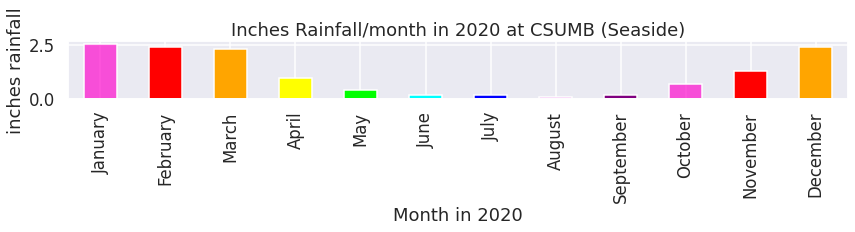

In [ ]:
#@title Graph CSUMB rainfall in 2020 with Pandas - graph 2020 CSUMB (Seaside/93955) rain data - take 1
bar_colors=['#f0ca','red','orange','yellow','lime','aqua','blue','violet','purple']
avgRain_copy['avgDailyRainfall_numeric'].plot.bar(color=bar_colors).set(xlabel="Month in 2020", ylabel="inches rainfall",title="Inches Rainfall/month in 2020 at CSUMB (Seaside)")

_=plt.xticks(range(0,len(avgRain_copy)),avgRain_copy['name'].to_numpy())#https://stackoverflow.com/questions/58814857/conversionerror-failed-to-convert-values-to-axis-units
#https://stackoverflow.com/questions/12056115/disable-the-output-of-matplotlib-pyplot

In [ ]:
print(climateAverages[0][0])
#perDay=climateAverages[0][0]['day']
#perDay.head()

{'month': [{'index': '1', 'name': 'January', 'avgMinTemp': '8.7', 'avgMinTemp_F': '47.6', 'absMaxTemp': '18.996902', 'absMaxTemp_F': '66.2', 'avgDailyRainfall': '2.52'}, {'index': '2', 'name': 'February', 'avgMinTemp': '8.1', 'avgMinTemp_F': '46.5', 'absMaxTemp': '17.743143', 'absMaxTemp_F': '63.9', 'avgDailyRainfall': '2.38'}, {'index': '3', 'name': 'March', 'avgMinTemp': '8.2', 'avgMinTemp_F': '46.8', 'absMaxTemp': '17.829254', 'absMaxTemp_F': '64.1', 'avgDailyRainfall': '2.28'}, {'index': '4', 'name': 'April', 'avgMinTemp': '8.8', 'avgMinTemp_F': '47.9', 'absMaxTemp': '18.99', 'absMaxTemp_F': '66.2', 'avgDailyRainfall': '0.96'}, {'index': '5', 'name': 'May', 'avgMinTemp': '10.0', 'avgMinTemp_F': '50.0', 'absMaxTemp': '20.990322', 'absMaxTemp_F': '69.8', 'avgDailyRainfall': '0.40'}, {'index': '6', 'name': 'June', 'avgMinTemp': '12.1', 'avgMinTemp_F': '53.8', 'absMaxTemp': '22', 'absMaxTemp_F': '71.6', 'avgDailyRainfall': '0.18'}, {'index': '7', 'name': 'July', 'avgMinTemp': '13.7', '

In [ ]:
#@title Current Weather Icon at 93955
currentCondition=pd.json_normalize(weather_json_parsed['data.current_condition'][0])
#currentCondition
#currentCondition.info()
currentWeatherIconURL=currentCondition['weatherIconUrl'][0][0]['value']
#currentWeatherIconURL
from IPython.display import Image
from IPython.core.display import HTML 
Image(url=currentWeatherIconURL)

In [ ]:
#@title API is not working as expected, trying other APIs:
#weather_json_parsed['weather'] # this api doesn't seem to be working right

# next api:
'''

Thank you for subscribing to Free OpenWeatherMap!

API key:
- Your API key is b66167d12183ce834c99e4373238c5ff
- Within the next couple of hours, it will be activated and ready to use
- You can later create more API keys on your account page
- Please, always use your API key in each API call

Endpoint:
- Please, use the endpoint api.openweathermap.org for your API calls
- Example of API call:
api.openweathermap.org/data/2.5/weather?q=London,uk&APPID=b66167d12183ce834c99e4373238c5ff

'''


w0.load_from_(''.join("""http://api.openweathermap.org/data/2.5/weather
?zip=93955,us
&APPID=b66167d12183ce834c99e4373238c5ff""".split('\n'))) # loads the json file from the remote url (limited probaby...)
w0.weather_json_parsed
wjp=w0.weather_json_parsed
#same with that one, neither one does dates


url = "https://dark-sky.p.rapidapi.com/37.774929,-122.419418,2019-02-20T10:22:22Z"

headers = {
	"X-RapidAPI-Host": "dark-sky.p.rapidapi.com",
	"X-RapidAPI-Key": "2c5a4ecf89msh066779aaa5c1d67p1f37e4jsn90cce2d0fb1a"
}

w0.load_from_(url,headers)
weather_json_parsed=w0.weather_json_parsed
weather_json_parsed.describe()
weather_json_parsed.info()
weather_json_parsed.head()
weather_json_parsed['hourly.summary']
weather_json_parsed['currently.temperature']
weather_json_parsed['currently.visibility']
weather_json_parsed['currently.time'] # always ends in ...142 so I'm really hoping that means the date parameter is working with this one...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   latitude                       1 non-null      float64
 1   longitude                      1 non-null      float64
 2   timezone                       1 non-null      object 
 3   offset                         1 non-null      int64  
 4   currently.time                 1 non-null      int64  
 5   currently.summary              1 non-null      object 
 6   currently.icon                 1 non-null      object 
 7   currently.precipIntensity      1 non-null      int64  
 8   currently.precipProbability    1 non-null      int64  
 9   currently.temperature          1 non-null      float64
 10  currently.apparentTemperature  1 non-null      float64
 11  currently.dewPoint             1 non-null      float64
 12  currently.humidity             1 non-null      float64

0    1550658142
Name: currently.time, dtype: int64

In [ ]:
#@title visual-crossing-weather.p.rapidapi.com/history is the only API giving us any date variation (for now...)
#...but I don't see any range option. Perhaps a loop, but that's multiple calls to the limited api.
# next api...this one is also on my c/c 500/mo hard limit whatever that means.. but it has date ranges....maybe...:


url = "https://visual-crossing-weather.p.rapidapi.com/history" # 500 queries/month, on c/c, perhaps pick a range and get a permanent file, or just be careful about making lots of queries


querystring = {
                "startDateTime":"2020-04-01T00:00:00"
               ,"aggregateHours":"24"
               ,"location":"Seaside,CA,USA"
               ,"endDateTime":"2020-04-30T00:00:00"
               ,"unitGroup":"us"
               ,"dayStartTime":"8:00:00"
               ,"contentType":"json"
               ,"dayEndTime":"17:00:00"
               ,"shortColumnNames":"0"
               }


headers = {
	"X-RapidAPI-Host": "visual-crossing-weather.p.rapidapi.com"
    ,"X-RapidAPI-Key": "2c5a4ecf89msh066779aaa5c1d67p1f37e4jsn90cce2d0fb1a"
}

#response = requests.request("GET", url, headers=headers, params=querystring)
#print(response.text)

weather_json_parsed=w0.load_from_(url,headers,querystring)
weather_json_parsed.describe()
weather_json_parsed.info()
weather_json_parsed.head()
weather_json_parsed.columns
weather_json_parsed.columns[0:25]
weather_json_parsed.columns[25:50]
weather_json_parsed['columns.precip.unit']
weather_json_parsed.columns[50:75]
weather_json_parsed.columns[75:125]

weather_json_parsed['locations.Seaside,CA,USA.values'] # finally that took a while to find - values
weather_json_parsed['locations.Seaside,CA,USA.values'][0]

querystring2 = {
                "startDateTime":"2021-04-01T00:00:00"
               ,"aggregateHours":"24"
               ,"location":"Seaside,CA,USA"
               ,"endDateTime":"2021-04-30T00:00:00"
               ,"unitGroup":"us"
               ,"dayStartTime":"8:00:00"
               ,"contentType":"json"
               ,"dayEndTime":"17:00:00"
               ,"shortColumnNames":"0"
               }

querystring3 = {
                "startDateTime":"2019-04-01T00:00:00"
               ,"aggregateHours":"24"
               ,"location":"Seaside,CA,USA"
               ,"endDateTime":"2019-04-30T00:00:00"
               ,"unitGroup":"us"
               ,"dayStartTime":"8:00:00"
               ,"contentType":"json"
               ,"dayEndTime":"17:00:00"
               ,"shortColumnNames":"0"
               }

querystring4 = {
                "startDateTime":"2018-04-01T00:00:00"
               ,"aggregateHours":"24"
               ,"location":"Seaside,CA,USA"
               ,"endDateTime":"2018-04-30T00:00:00"
               ,"unitGroup":"us"
               ,"dayStartTime":"8:00:00"
               ,"contentType":"json"
               ,"dayEndTime":"17:00:00"
               ,"shortColumnNames":"0"
               }
querystring5 = {
                "startDateTime":"2017-04-01T00:00:00"
               ,"aggregateHours":"24"
               ,"location":"Seaside,CA,USA"
               ,"endDateTime":"2017-04-30T00:00:00"
               ,"unitGroup":"us"
               ,"dayStartTime":"8:00:00"
               ,"contentType":"json"
               ,"dayEndTime":"17:00:00"
               ,"shortColumnNames":"0"
               }
querystring6 = {
                "startDateTime":"2016-04-01T00:00:00"
               ,"aggregateHours":"24"
               ,"location":"Seaside,CA,USA"
               ,"endDateTime":"2016-04-30T00:00:00"
               ,"unitGroup":"us"
               ,"dayStartTime":"8:00:00"
               ,"contentType":"json"
               ,"dayEndTime":"17:00:00"
               ,"shortColumnNames":"0"
               }
querystring7_2015 = {
                "startDateTime":"2015-04-01T00:00:00"
               ,"aggregateHours":"24"
               ,"location":"Seaside,CA,USA"
               ,"endDateTime":"2015-04-30T00:00:00"
               ,"unitGroup":"us"
               ,"dayStartTime":"8:00:00"
               ,"contentType":"json"
               ,"dayEndTime":"17:00:00"
               ,"shortColumnNames":"0"
               } # 20220617

weather21_json_parsed=w0.load_from_(url,headers,querystring2)
weather19_json_parsed=w0.load_from_(url,headers,querystring3)
weather18_json_parsed=w0.load_from_(url,headers,querystring4)
weather17_json_parsed=w0.load_from_(url,headers,querystring5)
weather16_json_parsed=w0.load_from_(url,headers,querystring6)
weather15_json_parsed=w0.load_from_(url,headers,querystring7_2015) # 20220617

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 128 entries, remainingCost to locations.Seaside,CA,USA.alerts
dtypes: float64(4), int64(31), object(93)
memory usage: 1.1+ KB


TL;DR: The api's aren't spitting out what I expected, especially with regard to date control, and without date control what are you going to predict? So I think this last one has date control, I just found it and spit out this last output, with date variation hopefully.


In [ ]:

weather_json_parsed['locations.Seaside,CA,USA.values'][0][0:30]#that's it one row/day, that's 10 rows/10 days

[{'cloudcover': 16.9,
  'conditions': 'Clear',
  'datetime': 1585728000000,
  'datetimeStr': '2020-04-01T08:00:00-07:00',
  'dew': 42.6,
  'heatindex': None,
  'humidity': 56.96,
  'info': None,
  'maxt': 60.2,
  'mint': 53.0,
  'precip': 0.0,
  'precipcover': 0.0,
  'sealevelpressure': 1017.9,
  'snow': 0.0,
  'snowdepth': 0.0,
  'solarenergy': 21.4,
  'solarradiation': 593.9,
  'temp': 58.0,
  'visibility': 9.9,
  'wdir': 293.2,
  'weathertype': '',
  'wgust': 26.3,
  'windchill': None,
  'wspd': 19.6},
 {'cloudcover': 0.0,
  'conditions': 'Clear',
  'datetime': 1585800000000,
  'datetimeStr': '2020-04-02T04:00:00-07:00',
  'dew': 38.5,
  'heatindex': None,
  'humidity': 52.32,
  'info': None,
  'maxt': 60.2,
  'mint': 47.0,
  'precip': 0.0,
  'precipcover': 0.0,
  'sealevelpressure': 1020.3,
  'snow': 0.0,
  'snowdepth': 0.0,
  'solarenergy': 11.3,
  'solarradiation': 525.2,
  'temp': 56.1,
  'visibility': 9.9,
  'wdir': 171.33,
  'weathertype': '',
  'wgust': None,
  'windchill': N

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


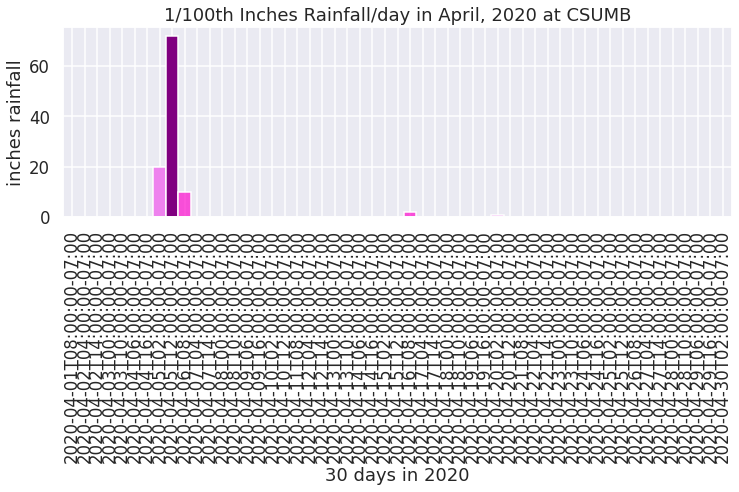

In [ ]:
#graph rainfall from 4/01 to 4/30, 2020:
#pd.DataFrame(weather_json_parsed['locations.Seaside,CA,USA.values'][0][0:10])['precip']
ten_day_frame=pd.DataFrame(weather_json_parsed['locations.Seaside,CA,USA.values'][0])
#print(ten_day_frame)
#precip0=100*ten_day_frame['precip'][:30]
precip0=100*ten_day_frame['precip'][:53]
precip0 # rain over 10 days in 2020
#print(precip0)
bar_colors=['#f0ca','red','orange','yellow','lime','aqua','blue','violet','purple']
precip0.plot.bar(color=bar_colors,width=1, stacked=True).set(xlabel="30 days in 2020", ylabel="inches rainfall",title="1/100th Inches Rainfall/day in April, 2020 at CSUMB")

_=plt.xticks(range(0,len(precip0)),ten_day_frame['datetimeStr'].to_numpy())#https://stackoverflow.com/questions/58814857/conversionerror-failed-to-convert-values-to-axis-units



Now that we finally got weather conditions per day, in groups of days, for any group of days we want, anywhere we want, maybe we can start attempting predictions.


Firstly, lets convert the datetime string into something more usable. We'll convert it into the number of days in the year it represents, along with a fraction for hourly information.

In [ ]:
from datetime import datetime
def datetimeStrtoInt(dateTimeStr):
  date = datetime.strptime(dateTimeStr, "%Y-%m-%dT%H:00:00-07:00")
  day_of_year = date.timetuple().tm_yday
  hourfraction = date.hour / 24
  return day_of_year + hourfraction

#sample = datetimeStrtoInt("2020-03-12T08:00:00-07:00")

#print(sample)


np.random.seed(42) #For repeatabilty, for now.

ten_day_frame['daynumber'] = ten_day_frame.datetimeStr.apply(datetimeStrtoInt)
ten_day_frame.head(50)

,wdir,temp,maxt,visibility,wspd,datetimeStr,solarenergy,heatindex,cloudcover,mint,...,sealevelpressure,snow,dew,humidity,precipcover,wgust,conditions,windchill,info,daynumber
0,293.20,58.0,60.2,9.9,19.6,2020-04-01T08:00:00-07:00,21.4,None,16.9,53.0,...,1017.9,0.0,42.6,56.96,0.0,26.3,Clear,NaN,None,92.333333
1,171.33,56.1,60.2,9.9,11.4,2020-04-02T04:00:00-07:00,11.3,None,0.0,47.0,...,1020.3,0.0,38.5,52.32,0.0,NaN,Clear,NaN,None,93.166667
2,307.00,61.1,62.0,9.9,15.0,2020-04-02T14:00:00-07:00,10.3,None,0.0,60.2,...,1020.3,0.0,42.1,49.56,0.0,NaN,Clear,NaN,None,93.583333
3,265.50,52.5,53.9,9.9,9.1,2020-04-03T00:00:00-07:00,1.4,None,27.9,51.1,...,1020.8,0.0,42.2,67.85,0.0,NaN,Partially cloudy,NaN,None,94.000000
4,296.00,57.8,60.2,9.9,15.0,2020-04-03T10:00:00-07:00,19.9,None,31.7,53.9,...,1020.1,0.0,42.7,57.26,0.0,21.9,Partially cloudy,NaN,None,94.416667
5,189.88,57.5,61.1,9.9,13.8,2020-04-04T06:00:00-07:00,9.6,None,87.3,51.1,...,1015.4,0.0,45.6,64.63,0.0,NaN,Overcast,NaN,None,95.250000
6,221.00,60.0,61.1,9.9,15.0,2020-04-04T16:00:00-07:00,2.1,None,95.8,59.0,...,1012.8,0.0,49.4,67.93,0.0,23.0,Overcast,NaN,None,95.666667
7,177.00,57.1,57.8,8.1,12.8,2020-04-05T02:00:00-07:00,2.3,None,78.2,56.0,...,1007.2,0.0,49.7,76.39,100.0,20.8,"Rain, Overcast",NaN,None,96.083333
8,252.50,54.8,56.0,2.8,9.2,2020-04-05T12:00:00-07:00,1.8,None,82.9,53.0,...,1007.3,0.0,50.4,85.10,100.0,19.7,"Rain, Overcast",NaN,None,96.500000
9,198.40,52.9,56.9,9.8,17.0,2020-04-06T08:00:00-07:00,16.3,None,59.0,47.9,...,1012.9,0.0,42.9,69.47,70.0,21.9,"Rain, Partially cloudy",44.7,None,97.333333


Now lets get into the kNN regressor. We'll use the new daynumber value as our predictor, and attempt to target the precipitation value using this. We'll explore more optimal hyperparameters later, but for now, lets attempt the defaults.

In [ ]:
def rmse(predicted, actual):
    return np.sqrt(((predicted - actual)**2).mean())

predictors = ['daynumber']
#dropping categorical features, such as ocean_proximity, including spatial ones such as long/lat.
target = 'precip'
X = ten_day_frame[predictors].values
y = ten_day_frame[target].values

indexes = np.random.choice(y.size, size=10000)
X_mini = X[indexes]
y_mini = y[indexes]

# Split the data into training and test sets, and scale
scaler = StandardScaler()

# unscaled version (note that scaling is only used on predictor variables)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_mini, y_mini, test_size=0.30, random_state=42)

# scaled version
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)


#Baseline

blindguess = rmse(np.mean(y_train), y_test)
print("Blind guess RMSE: " + str(blindguess))

#Predictions

knn = KNeighborsRegressor(algorithm='brute')
knn.fit(X_train, y_train)
predicted = knn.predict(X_test)
trainrmse = rmse(predicted, y_test)
print("kNN guess RMSE: " + str(trainrmse))

Blind guess RMSE: 0.10287613182852474
kNN guess RMSE: 0.0


Admittedly highly successful, though we may wish to scale the Y values to get some RMSE's that aren't miniscule. We can engage in this and hyperparameter improvements in subsequent work.

OK, now that we've got a proof of concept going, lets upgrade this to operate on several years worth of data, and attempt to predict a new years rainfall using prior years data. For the purposes of this question, lets get data from 2016-2020, and then attempt to predict 2021's rainfall from it.

First lets train using multiple years, which will likely reduce the effectiveness of the trained guesses, but will generalize the solution considerably.

In [ ]:
df2020=pd.DataFrame(weather_json_parsed['locations.Seaside,CA,USA.values'][0])
df2016=pd.DataFrame(weather16_json_parsed['locations.Seaside,CA,USA.values'][0])
df2017=pd.DataFrame(weather17_json_parsed['locations.Seaside,CA,USA.values'][0])
df2018=pd.DataFrame(weather18_json_parsed['locations.Seaside,CA,USA.values'][0])
df2019=pd.DataFrame(weather19_json_parsed['locations.Seaside,CA,USA.values'][0])
df2021=pd.DataFrame(weather21_json_parsed['locations.Seaside,CA,USA.values'][0])
df2015=pd.DataFrame(weather15_json_parsed['locations.Seaside,CA,USA.values'][0]) # 20220617

trainyears = [df2016,df2017,df2018,df2019,df2020]
traindf = pd.concat(trainyears)
traindf['daynumber'] = traindf.datetimeStr.apply(datetimeStrtoInt)

df2021['daynumber'] = df2021.datetimeStr.apply(datetimeStrtoInt)
df2015['daynumber'] = df2021.datetimeStr.apply(datetimeStrtoInt) # 20220617

#Test on the traindf only

predictors = ['daynumber']
#dropping categorical features, such as ocean_proximity, including spatial ones such as long/lat.
target = 'precip'
X = traindf[predictors].values
y = traindf[target].values

indexes = np.random.choice(y.size, size=10000)
X_mini = X[indexes]
y_mini = y[indexes]

# Split the data into training and test sets, and scale
scaler = StandardScaler()

# unscaled version (note that scaling is only used on predictor variables)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_mini, y_mini, test_size=0.30, random_state=43)

# scaled version
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

#Baseline

blindguess = rmse(np.mean(y_train), y_test)
print("Blind guess RMSE: " + str(blindguess))

#Predictions

knn = KNeighborsRegressor(algorithm='brute')
knn.fit(X_train, y_train)
predicted = knn.predict(X_test)
trainrmse = rmse(predicted, y_test)
print("kNN guess RMSE: " + str(trainrmse))

#As predicted, including multiple years reduced the effectiveness of the guess, but still outperforms blind guessing
#This is due to the fact that differing years probably have differing weather patterns - drought, for instance, is likely a factor in several years but not others.

Blind guess RMSE: 0.06703548342046149
kNN guess RMSE: 0.0565160390213846


That's not so bad, even if not a dramatic improvement over blind guesses. OK, now lets try to predict an entirely new year with this data.


In [ ]:
newvals = df2021[predictors].values
newvals = scaler.fit_transform(newvals)
newtarget = df2021[target].values

#Baseline

blindguess = rmse(np.mean(y_train), newtarget)
print("Blind guess RMSE: " + str(blindguess))

#Predictions

predicted = knn.predict(newvals)
trainrmse = rmse(predicted, newtarget)
print("kNN guess RMSE: " + str(trainrmse))


Blind guess RMSE: 0.012635714285714285
kNN guess RMSE: 0.04221150697090447


Unfortunately, its clear that we are failing quite badly at predicting the future with our historical data. Using the trainer from 2016-2020, we do considerably worse (around 6 times worse) than just blindly averaging the monthly rainfall from those prior years, when trying to predict the rainfall on any specific day in April.

It is likely that attempting to model a system as complex as weather using simple historical data was fairly doomed, no matter what machine learning we used (kNN, linear, decision trees, etc) - as weather patterns can change based on drought patterns, storms, climate patterns such as El Nino/La Nina, or climate change. Nevertheless, future exploration might explore the possiblity of additional data (we only used 4 years as input). The success of the averages might also point to our ambitions being too high in attempting to find a specific day - perhaps seeking a monthly average, using monthly averages of April's over specific years might have been more successful, but considerably less useful for the field of prediction.

If we were to continue this in the future, it might also be worth thinking about potential predictors (ocean temperature, humidity in months prior to April might be useful indicators) that we did not fully explore.

In [ ]:
# some more tests with the one predictor:
    
newvals = df2015[predictors].values
newvals = scaler.fit_transform(newvals)
newtarget = df2015[target].values

#Baseline

blindguess = rmse(np.mean(y_train), newtarget)
print("Blind guess RMSE: " + str(blindguess)) # Blind guess RMSE: 0.02420052003820101 # 2.4% error

#Predictions

predicted = knn.predict(newvals)
trainrmse = rmse(predicted, newtarget)
print("kNN guess RMSE: " + str(trainrmse)) # kNN guess RMSE: 0.05124708919483521 # 5% error


In [ ]:
#Now we will try adding a feature or two to see if we can't improve the predictions.

ten_day_frame.head(50) # a little more investigation
ten_day_frame.columns # a little more investigation

Index(['wdir', 'temp', 'maxt', 'visibility', 'wspd', 'datetimeStr',
       'solarenergy', 'heatindex', 'cloudcover', 'mint', 'datetime', 'precip',
       'solarradiation', 'weathertype', 'snowdepth', 'sealevelpressure',
       'snow', 'dew', 'humidity', 'precipcover', 'wgust', 'conditions',
       'windchill', 'info', 'daynumber'],
      dtype='object')

Now lets get into the kNN regressor. We'll use the new daynumber value as our predictor, and attempt to target the precipitation value using this. We'll explore more optimal hyperparameters later, but for now, lets attempt the defaults.

In [ ]:
predictors = ['daynumber','humidity'] # humidity too, instead of just daynumber now
target = 'precip'
X = ten_day_frame[predictors].values
y = ten_day_frame[target].values


indexes = np.random.choice(y.size, size=10000)
X_mini = X[indexes]
y_mini = y[indexes]

# Split the data into training and test sets, and scale
scaler = StandardScaler()

# unscaled version (note that scaling is only used on predictor variables)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_mini, y_mini, test_size=0.30, random_state=42)

# scaled version
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)


#Baseline

blindguess = rmse(np.mean(y_train), y_test)
print("Blind guess RMSE: " + str(blindguess)) # Blind guess RMSE: 0.09490569190761208 9% error, 1% lower!

#Predictions

knn = KNeighborsRegressor(algorithm='brute')

knn.fit(X_train, y_train)
predicted = knn.predict(X_test)
trainrmse = rmse(predicted, y_test)
print("kNN guess RMSE: " + str(trainrmse)) # 0.0 like before


Blind guess RMSE: 0.09490569190761208
kNN guess RMSE: 0.0


As before, successful, although we may wish to scale the Y values to get some RMSE's that aren't miniscule. We can engage in this and hyperparameter improvements in subsequent work.

OK, now that we've got a proof of concept going, lets upgrade this to operate on several years worth of data, and attempt to predict a new years rainfall using prior years data. For the purposes of this question, lets get data from 2016-2020, and then attempt to predict 2021's rainfall from it.

First lets train using multiple years, which will likely reduce the effectiveness of the trained guesses, but will generalize the solution considerably.

In [ ]:
df2020=pd.DataFrame(weather_json_parsed['locations.Seaside,CA,USA.values'][0])
df2016=pd.DataFrame(weather16_json_parsed['locations.Seaside,CA,USA.values'][0])
df2017=pd.DataFrame(weather17_json_parsed['locations.Seaside,CA,USA.values'][0])
df2018=pd.DataFrame(weather18_json_parsed['locations.Seaside,CA,USA.values'][0])
df2019=pd.DataFrame(weather19_json_parsed['locations.Seaside,CA,USA.values'][0])
df2021=pd.DataFrame(weather21_json_parsed['locations.Seaside,CA,USA.values'][0])

trainyears = [df2016,df2017,df2018,df2019,df2020]
traindf = pd.concat(trainyears)
traindf['daynumber'] = traindf.datetimeStr.apply(datetimeStrtoInt)

df2021['daynumber'] = df2021.datetimeStr.apply(datetimeStrtoInt)

#Test on the traindf only

predictors = ['daynumber','humidity'] # adding in humidity again here
#dropping categorical features, such as ocean_proximity, including spatial ones such as long/lat.
target = 'precip'
X = traindf[predictors].values
y = traindf[target].values

indexes = np.random.choice(y.size, size=10000)
X_mini = X[indexes]
y_mini = y[indexes]

# Split the data into training and test sets, and scale
scaler = StandardScaler()

# unscaled version (note that scaling is only used on predictor variables)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_mini, y_mini, test_size=0.30, random_state=43)

# scaled version
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

#Baseline

blindguess = rmse(np.mean(y_train), y_test)
print("Blind guess RMSE: " + str(blindguess)) # Blind guess RMSE: 0.06217718780222533 # 6.2% error, or 0.5% lower with humidity as a predictor!

#Predictions

knn = KNeighborsRegressor(algorithm='brute')
knn.fit(X_train, y_train)
predicted = knn.predict(X_test)
trainrmse = rmse(predicted, y_test)
print("kNN guess RMSE: " + str(trainrmse)) # kNN guess RMSE: 8.012344526598184e-19 #!!! Super low, right? That was 5.65% error without humidity!


Blind guess RMSE: 0.06217718780222533
kNN guess RMSE: 9.480333893807276e-19


That is very low error after adding humidity as a second predictor.

Now lets try to predict an entirely new year with this data.

In [ ]:

newvals = df2021[predictors].values
newvals = scaler.fit_transform(newvals)
newtarget = df2021[target].values

#Baseline

blindguess = rmse(np.mean(y_train), newtarget)
print("Blind guess RMSE: " + str(blindguess)) # Blind guess RMSE: 0.012551428571428573 # or 1.255% error, just a little lower for that one

#Predictions

predicted = knn.predict(newvals)
trainrmse = rmse(predicted, newtarget)
print("kNN guess RMSE: " + str(trainrmse)) # kNN guess RMSE: 0.09464930304042252 # 9% error, which is way up, so I'm not sure, 2021 was wierd.

Blind guess RMSE: 0.012551428571428573
kNN guess RMSE: 0.09464930304042252


At first it seemed like adding humidity worked but the prediction of another year went down.
Lets see it for the 2015 prediction:

In [ ]:
newvals = df2015[predictors].values
newvals = scaler.fit_transform(newvals)
newtarget = df2015[target].values

#Baseline

blindguess = rmse(np.mean(y_train), newtarget)
print("Blind guess RMSE: " + str(blindguess)) # Blind guess RMSE: 0.0242 # or 1.255% error, just a little lower for that one

#Predictions

predicted = knn.predict(newvals)
trainrmse = rmse(predicted, newtarget)
print("kNN guess RMSE: " + str(trainrmse)) # kNN guess RMSE: 0.03353398726496437 # 3% error, which is down 1%!!

Blind guess RMSE: 0.02401800376251603
kNN guess RMSE: 0.03353398726496437


It looks like error went down a little for the 2015 prediction, adding the humidity predictor in, from 4% to 3%.

